In [19]:
#general
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

#machine learning 
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.arima.model import ARIMA

#helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

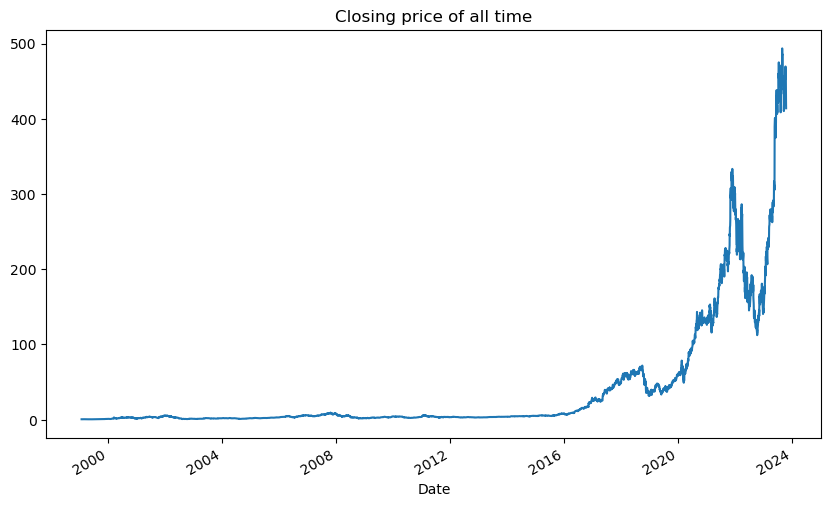

In [20]:
#getting a dataframe containing all pass NVDA stock prices 
nvda = yf.Ticker("NVDA")
nvda_df = nvda.history(period='max')
nvda_df['Close'].plot()
plt.title("Closing price of all time")
plt.show()
#upon plotting all historic data of NVDA, we see significanet change from
#2018 onwards, which is more relevant to the current contexta

In [21]:
#download NVDA stock data from 2017 to now
df = yf.download('NVDA', '2017-1-1', '2023-10-14')

[*********************100%%**********************]  1 of 1 completed


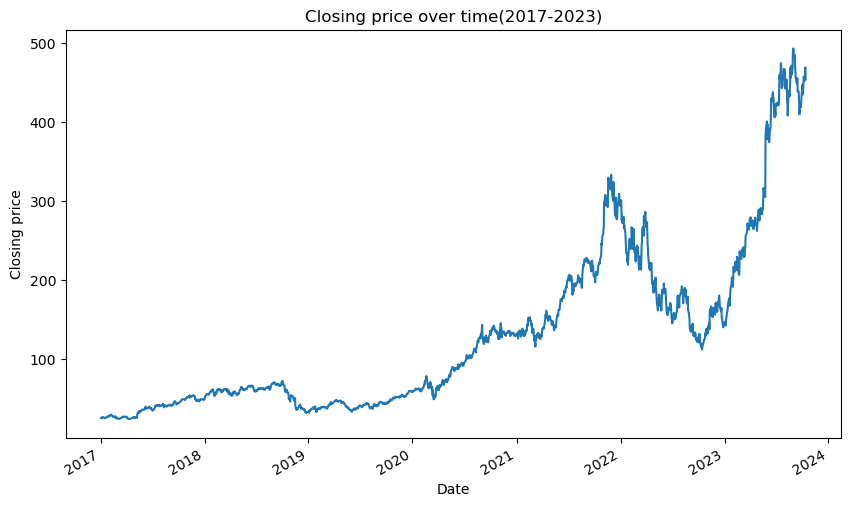

In [22]:
df['Close'].plot(use_index=True)
plt.ylabel("Closing price")
plt.title("Closing price over time(2017-2023)")
plt.show()

In [23]:
#creating training and test data for ARIMA model 
df_arima = df
df_close = df['Close']
arima_train = df_arima['Close'][:round(len(df_arima["Close"])*0.8)]
arima_test = df_arima['Close'][round(len(df_arima["Close"])*0.2):]




<Figure size 1000x600 with 0 Axes>

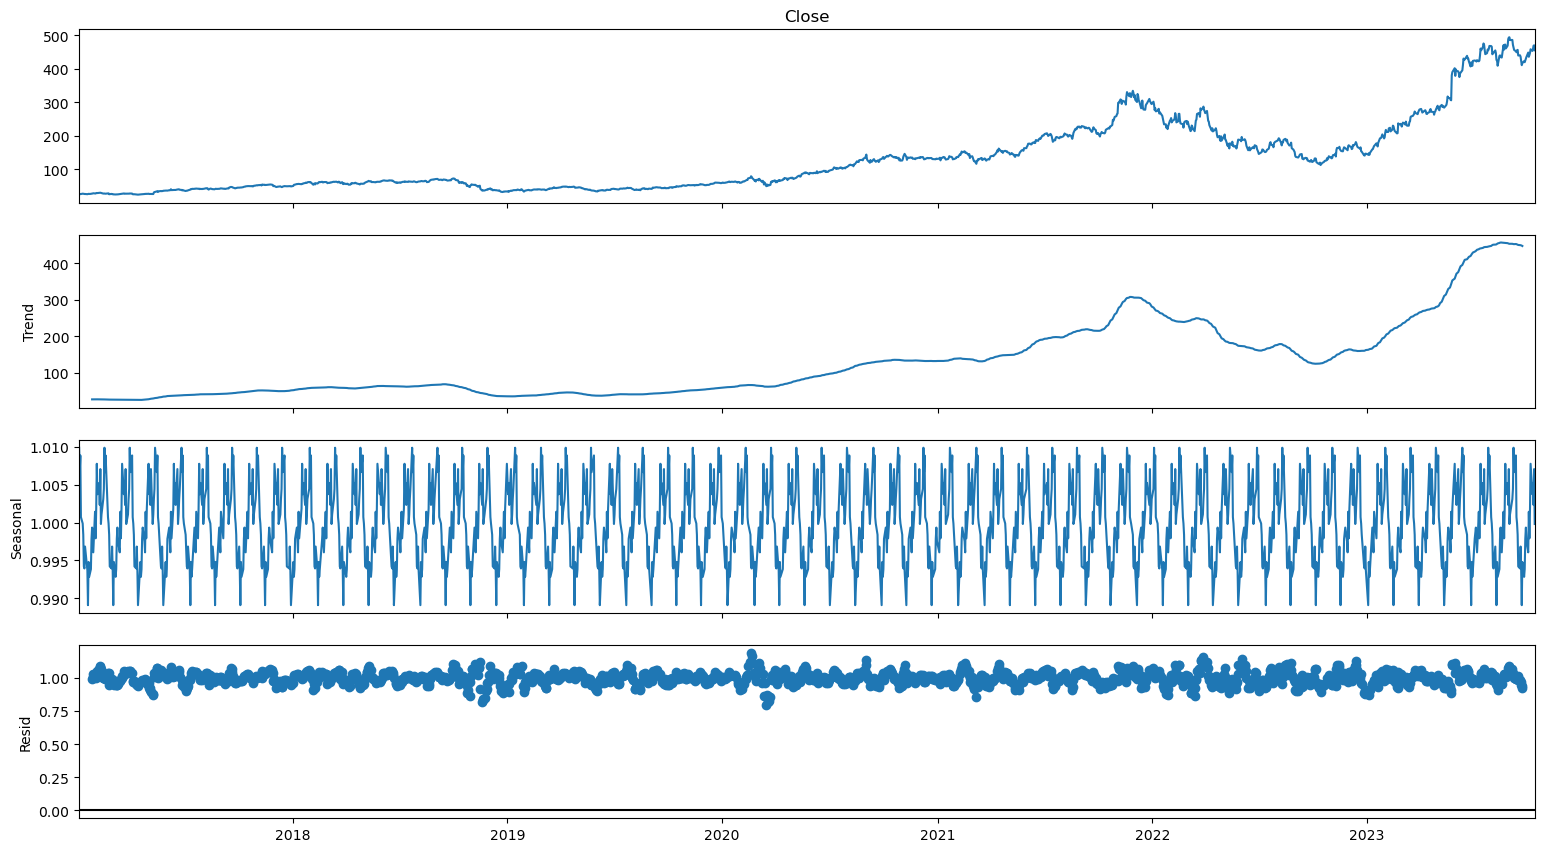

In [24]:
#Separate trend and seasonality from time series
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


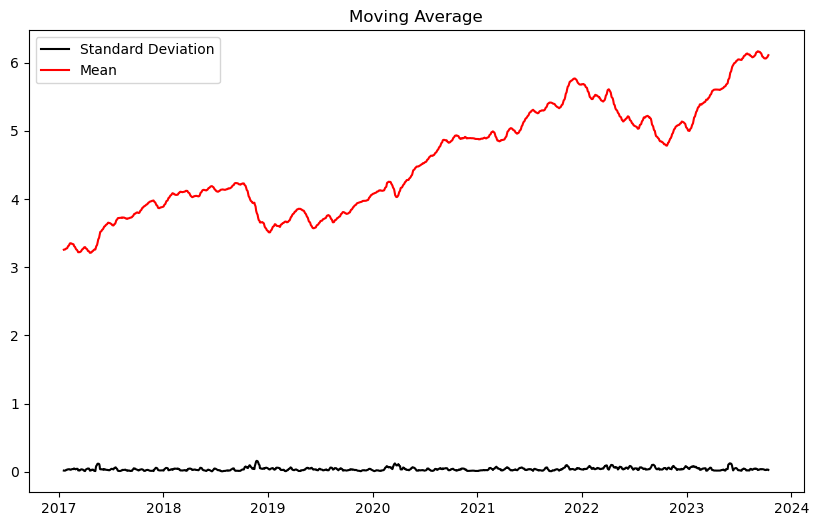

In [25]:
#visualise the changes in moving average, as well as standard deviation.

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

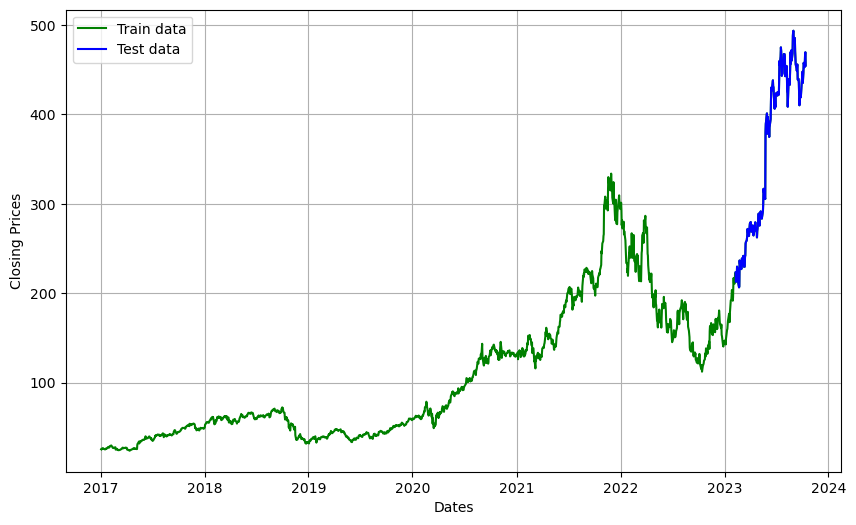

In [26]:
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


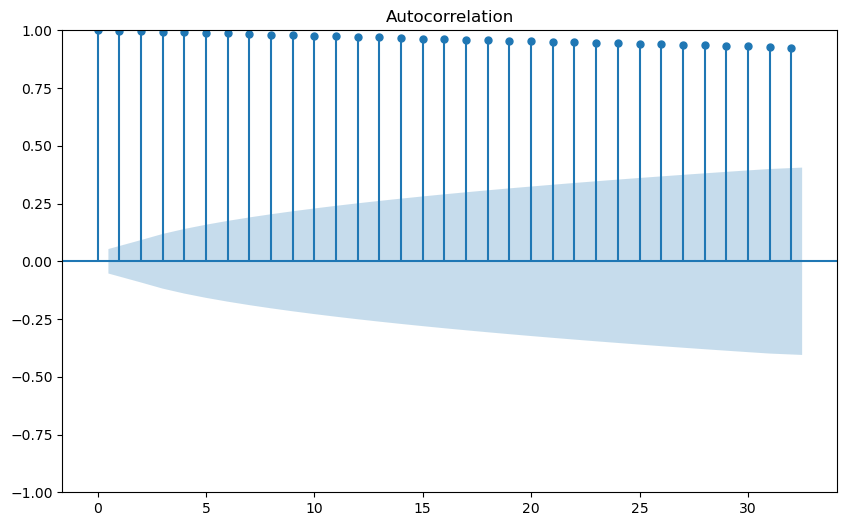

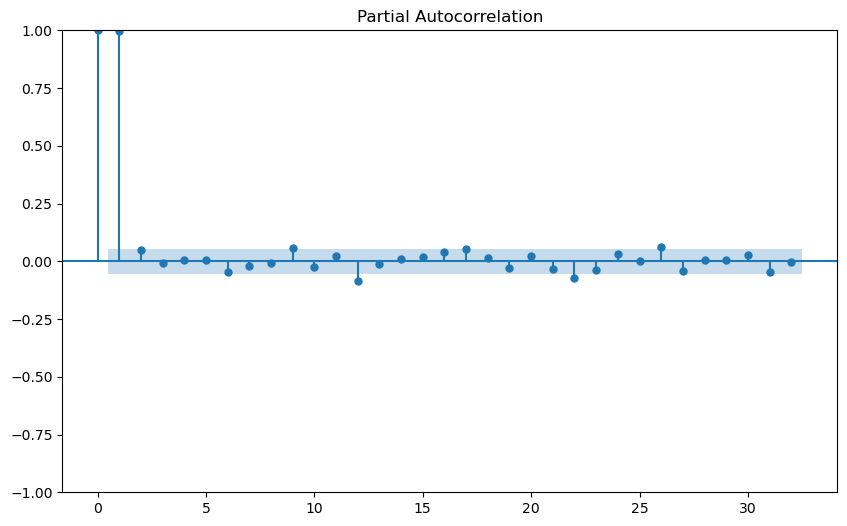

In [27]:
#time series of Random Walk is observed, so we can conclude that there is no stationarity in the time series
#given the need to transform the time series into one that is stationary, we will use the ARIMA model.  

#from acf graph, we can see high correlation with slow decay towards 0
#from the pcaf graph, we see a large spike at lag 1 and 2 before a "cut off" at lag2. Thus we will use an order of 2 for an AR(2) model.
#we shall use an ARIMA(2,d,0) model

acf_graph = plot_acf(arima_train)
pacf_graph = plot_pacf(arima_train)

<Axes: xlabel='Date'>

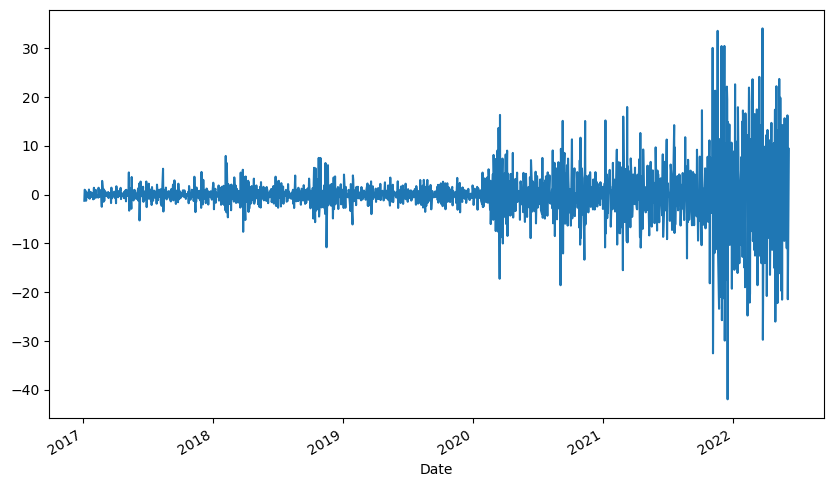

In [28]:
#trasnforming to startionary via differencing
t_arima_train = arima_train.diff().dropna()
t_arima_train2 = t_arima_train.diff().dropna() 
t_arima_train2.plot()

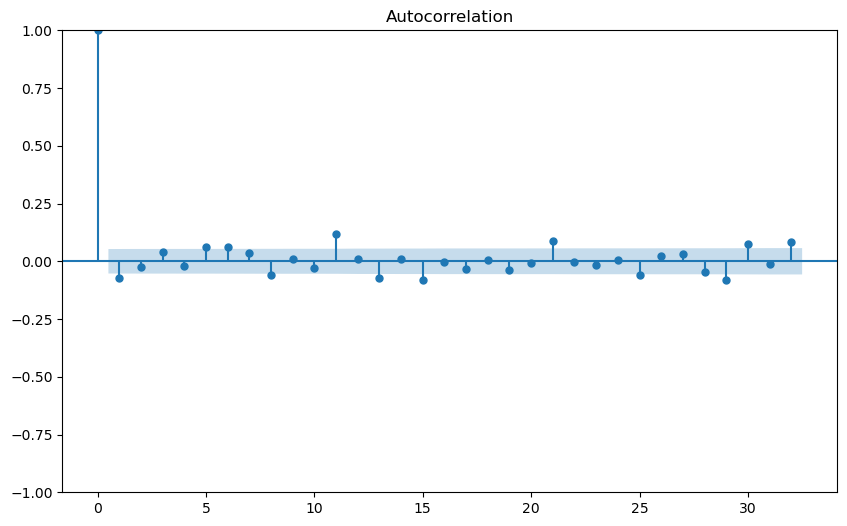

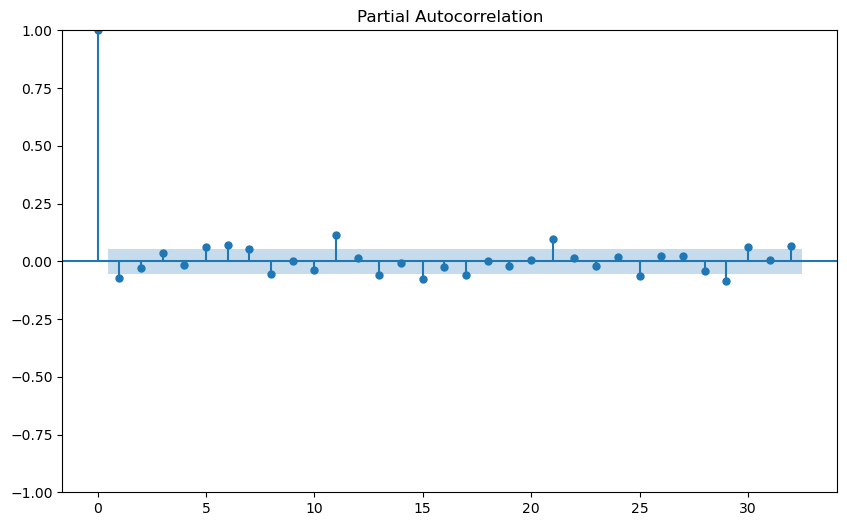

In [29]:
#for both acf and pacf of transformed data, high correlation is only observed at lag zero. Thus there is stationarity of the time series
t_acf_graph = plot_acf(t_arima_train)
t_pacf_graph = plot_pacf(t_arima_train)

#as only a single differencing is required to achieve stationarity in time series, we can conclude ARIMA(2,1,q) shall be used

In [30]:
#fitting our ARIMA Model based on the obtained orders
model = ARIMA(test_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  171
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -646.814
Date:                Mon, 23 Oct 2023   AIC                           1299.628
Time:                        01:33:38   BIC                           1309.035
Sample:                             0   HQIC                          1303.445
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0114      0.087      0.131      0.896      -0.160       0.182
ar.L2         -0.0053      0.087     -0.062      0.951      -0.175       0.164
sigma2       118.1184      4.989     23.675      0.0

/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
#Prediction from my fitted ARIMA model
results = fitted.predict(dynamic=False)
results = results[-10:]
results = results.to_frame()
results = results.rename({'predicted_mean': 'Close'}, axis='columns')
results = results.reset_index()
results = results.drop(columns=['Date'], axis='columns')
results.index.name='Index'

In [ ]:
results.to_csv("kaggle_submission.csv", sep=',', index=True, encoding='utf-8')